# Background

The fold card allows the user to get sats back on purchases rather than a percentage of the purchase in fiat. Speciifcally, it is not a static percentage of the purchase the user gets back, but an opportunity to spin a random wheel for varying levels of sats back. The wheel, sats back, and percentages change on a regular basis. Once a user spins, they may accept their spin result or use earned additional spins to improve their sats back. 

Fold changes the wheel every month to six weeks. The possible awards and their odds change with each wheel. 

# Method
Each wheel is added to this analysis when it has at least 100 spins including original spins, respins, and respins using spin bombs. Some awards have stated odds of <1%, and these are excluded. Also, spin results that did not occur in the sample were ignored in this analysis. 

The initial sample is used to bootstrap larger random samples and the distribution of the resulting frequencies was compared to the published expected frequencies.

In [27]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First, let's identify what wheel you wish to use by uncommenting it below:

In [28]:
file = 'Easter_Wheel.csv'
#file = 'March_April.csv'
#file = 'March_Renew_Wheel.csv'
# file = 'March_Wheel.csv'
# file = 'February_Wheel.csv'
# file = 'New_Year_Wheel.csv'

First, let's bring in Fold's published odds as our expected frequencies (Exp_Freq).

In [29]:
expected_df = pd.read_csv('Expected_Rewards.csv')
col_name,_ = file.split('.')
expected_df = expected_df[['Award',col_name]].dropna()
expected_df.rename(columns={col_name:'Exp_Freq'},inplace=True)

print(f'Expected rewards for {col_name}\n')
print(expected_df)
print('\nTotal does not equal 100% because we drop those awards that have expected frequency of less than 1%')


Expected rewards for Easter_Wheel

       Award  Exp_Freq
1    2 spins  0.067899
3        Dep  0.070000
4   Lg_purch  0.060000
5      Purch  0.060000
7   100 sats  0.080000
9      0.25%  0.080000
10     0.50%  0.080000
11     0.75%  0.120000
12        1%  0.140000
13     1.50%  0.120000
14        2%  0.050000
15        3%  0.040000
16        4%  0.030000
20     Total  0.992900

Total does not equal 100% because we drop those awards that have expected frequency of less than 1%


Now, we'll take a look at the observed spins from the chosen wheel.

In [30]:
df = pd.read_csv(file)
print(df)
observations = df.shape[0]
print(f'The first 5 of the list of rewards of {observations} spins')
obs_spins = df.SPIN_RESULT.tolist()
obs_spins[0:5]
spins_set_list = list(set(obs_spins))


    SPIN_RESULT
0           Dep
1         0.75%
2         0.75%
3            2%
4          1.5%
..          ...
98          Dep
99        0.25%
100          1%
101          1%
102    Lg_purch

[103 rows x 1 columns]
The first 5 of the list of rewards of 103 spins


In [31]:
#create dataframe of observed spins frequency
observed_df = pd.DataFrame(pd.DataFrame({'Result':obs_spins}).value_counts(normalize=True),columns=['Freq'])
observed_df['Type']='Obs_Freq'
observed_df.reset_index(inplace=True,drop=False)
observed_df = observed_df[observed_df.Result.isin(expected_df['Award'].tolist())]
observed_df

,Result,Freq,Type
0,0.75%,0.184466,Obs_Freq
1,1%,0.135922,Obs_Freq
3,Dep,0.106796,Obs_Freq
4,Purch,0.087379,Obs_Freq
5,0.25%,0.067961,Obs_Freq
7,2 spins,0.067961,Obs_Freq
8,Lg_purch,0.067961,Obs_Freq
9,100 sats,0.038835,Obs_Freq
10,2%,0.038835,Obs_Freq
11,3%,0.009709,Obs_Freq


Now let's bring these together for an initial look.

In [32]:
expected_df
expected_df.rename(columns={'Award':'Result','Exp_Freq':'Freq'},inplace=True)
exp_set_list = expected_df.Result.tolist()
expected_df['Type'] = 'Expected_Freq'
expected_df=expected_df[expected_df.Result!='Total']
expected_df = expected_df[expected_df.Result.isin(list(set(obs_spins)))] #removes any expected spin that didn't occur

observed_df = observed_df[observed_df['Result'].isin(exp_set_list)]
df=observed_df.append(expected_df,ignore_index=True)

df

,Result,Freq,Type
0,0.75%,0.184466,Obs_Freq
1,1%,0.135922,Obs_Freq
2,Dep,0.106796,Obs_Freq
3,Purch,0.087379,Obs_Freq
4,0.25%,0.067961,Obs_Freq
5,2 spins,0.067961,Obs_Freq
6,Lg_purch,0.067961,Obs_Freq
7,100 sats,0.038835,Obs_Freq
8,2%,0.038835,Obs_Freq
9,3%,0.009709,Obs_Freq


And we can visualize this for an ituitive first look.

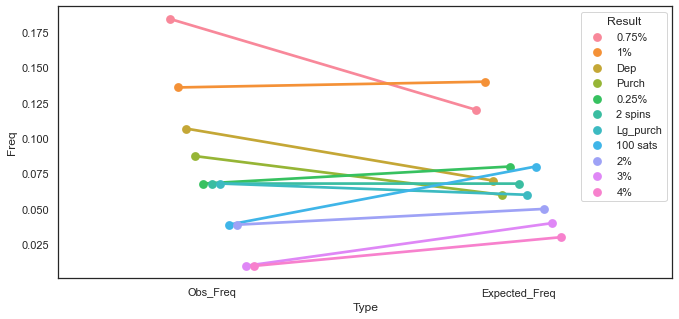

In [33]:
sns.set(rc={'figure.figsize':(11,5)})
sns.set_style('white')
sns.pointplot(x=df.Type, y=df.Freq,hue=df.Result,data=df,dodge=True);

A horizontal line in the graph above shows that the observed frequency and the expected frequency are the same. Lines with negative slope show rewards that occur more frequently than expected. Lines with positive slope show rewards that occur less frequency than expected.

But what we can't see from this pointplot is any statistical validity in this assessment. Normally, with only about 100 observations of so many outcomes, we wouldn't have the power to do any statistical validity. However, bootstrapping or resampling with replacement offers us a chance to create confidence intervals to compare observed results with. 

We can iterate the list of observed rewards, create bootstrapped distributions from them and map the observed frequency on that distribution.

Green lines are 95% confidence intervals of the distributions in blue
Red line is observed frequency
['2 spins', 'Dep', 'Lg_purch', 'Purch', '100 sats', '0.25%', '0.75%', '1%', '2%', '3%', '4%']
2 spins
   index   Result      Freq           Type
0      1  2 spins  0.067899  Expected_Freq
   index   Result      Freq      Type
0      7  2 spins  0.067961  Obs_Freq
Dep
   index Result  Freq           Type
0      3    Dep  0.07  Expected_Freq
   index Result      Freq      Type
0      3    Dep  0.106796  Obs_Freq
Lg_purch
   index    Result  Freq           Type
0      4  Lg_purch  0.06  Expected_Freq
   index    Result      Freq      Type
0      8  Lg_purch  0.067961  Obs_Freq
Purch
   index Result  Freq           Type
0      5  Purch  0.06  Expected_Freq
   index Result      Freq      Type
0      4  Purch  0.087379  Obs_Freq
100 sats
   index    Result  Freq           Type
0      7  100 sats  0.08  Expected_Freq
   index    Result      Freq      Type
0      9  100 sats  0.038835  Obs_Freq

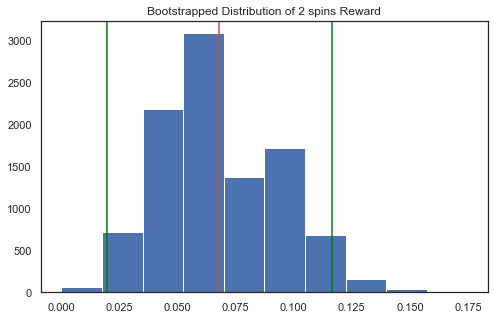

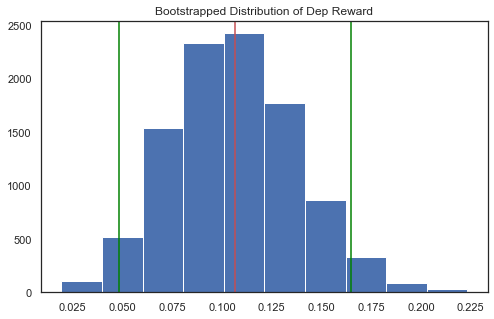

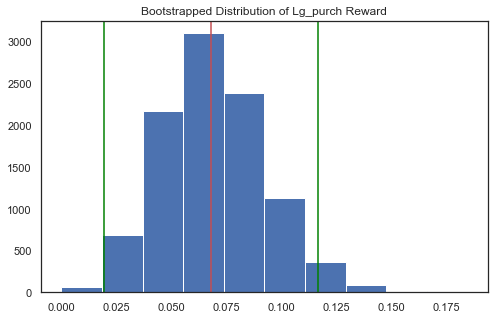

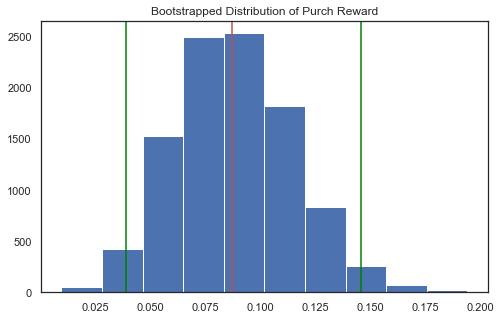

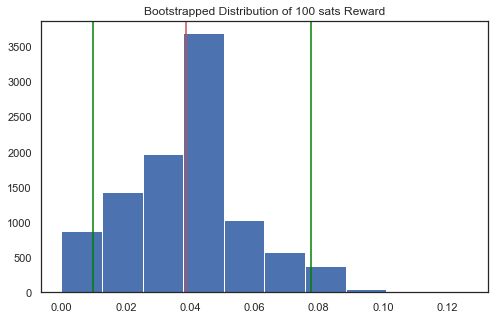

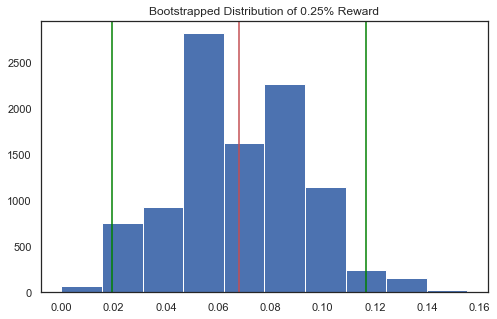

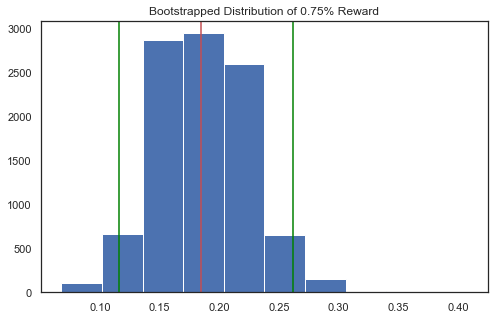

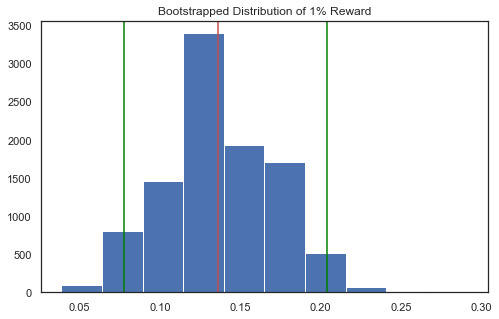

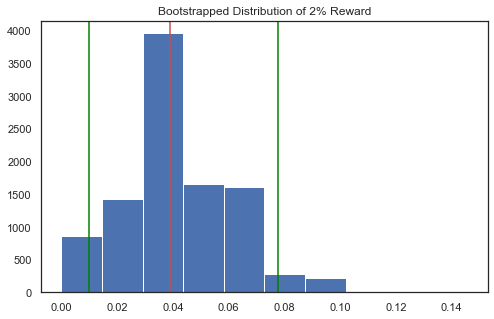

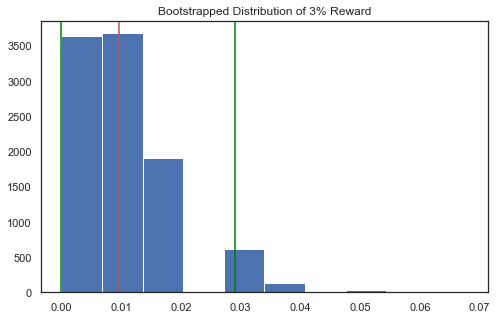

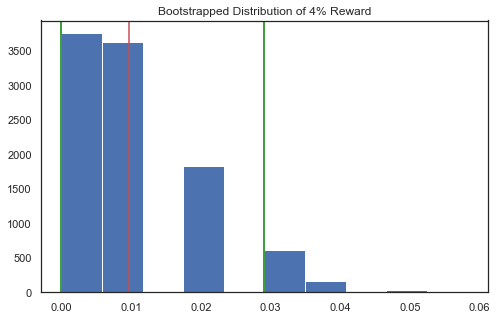

In [39]:
print('Green lines are 95% confidence intervals of the distributions in blue')
print('Red line is observed frequency')
exp_set_list = [x for x in exp_set_list if x in observed_df.Result.tolist()]
print(exp_set_list)
spins = np.array(obs_spins)
for award in exp_set_list:
    print(award)
    temp = expected_df[expected_df.Result==award].reset_index()
    temp1 = observed_df[observed_df.Result==award].reset_index()
    obs_freq = temp1.Freq.tolist()[0]
    award_freqs=[]
    for i in range(10000):
        #create bootstrap sample
        boot = np.random.choice(spins,spins.size,replace=True)
        # find resulting frequency for 30-day purchases
        award_freq = boot[boot==award].size/boot.size
        award_freqs.append(award_freq)
    plt.figure(figsize=(8,5))
    array = np.array(award_freqs)
#     p = (np.array(award_freqs) <= obs_freq).mean()
    tile_25 = np.percentile(array,2.5)
    tile_975 = np.percentile(array,97.5)
    plt.axvline(tile_25,color='green')
    plt.axvline(tile_975,color='green')
    plt.title(f'Bootstrapped Distribution of {award} Reward')
    plt.hist(award_freqs)
        
    plt.axvline(obs_freq,color='r');
    
